# Evaluation Suite for T5-small Phoneme-to-Text Model
### Computes CER, WER, BLEU, chrF, Error Breakdown, Dataset Stats

This notebook evaluates the fine-tuned T5-small IPA→Text model using standard ASR metrics across a representative sample of phoneme/text pairs. The workflow reflects the broader challenges documented in child-speech ASR research: high phonological variability, acoustic mismatch, and the need for reliable, low-noise supervision when training text-generation models. Because children's speech introduces unpredictable substitutions, omissions, and phonological processes that degrade recognition performance in even state-of-the-art systems (e.g., Whisper, wav2vec2, Conformers), evaluation requires metrics sensitive to both character-level and word-level errors, as well as substitution/insertion/deletion patterns. This notebook establishes that framework by generating predictions, computing CER/WER/BLEU/chrF, analyzing error types, and visualizing dataset statistics and training-loss behavior. The resulting evaluation pipeline is reproducible, model-agnostic, and aligned with the methodological standards used in ASR research.

---

### Step 1: Install prerequisites

In [ ]:
!pip install -q evaluate jiwer pandas matplotlib

In [ ]:
!pip install -q sacrebleu jiwer==3.0.3

### Step 2: Mount Google Drive

In [ ]:
# ---- Mount Google Drive ----
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 3: Load Model, Data, Generate Predictions, and Compute Metrics

Loads the fine-tuned T5 model and tokenizer, samples a subset of the evaluation dataset, generates text predictions from IPA input, and computes CER, WER, BLEU, and chrF.

The section also produces a substitution/insertion/deletion breakdown and summarizes phoneme/text sentence-length statistics.

Generating predictions: 100%|██████████| 2000/2000 [09:16<00:00,  3.60it/s]



=== Evaluation Metrics ===
Character Error Rate (CER): 0.1398
Word Error Rate (WER):      0.2473
BLEU Score:                 0.5998
chrF Score:                 77.75

--- Error Breakdown ---
Substitution Rate: 0.179
Insertion Rate: 0.029
Deletion Rate: 0.039

--- Dataset Statistics ---
        phon_len   text_len
mean   44.589500  13.292500
std    25.861601   7.129471
min     9.000000   5.000000
max   150.000000  42.000000


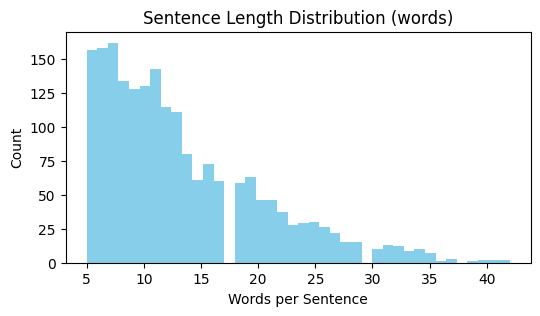

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
from evaluate import load
from jiwer.measures import compute_measures

# --------------------------------------------------------------
# Load tokenizer and model from Hugging Face (or local folder)
# --------------------------------------------------------------
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "zanegraper/t5-small-ipa-phoneme-to-text"  # or local path
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to("cuda")

# --------------------------------------------------------------
# Load dataset (or use your validation split)
# --------------------------------------------------------------
csv_path = "/content/drive/MyDrive/Capstone/Corpus/bookcorpus_ipa_final.csv"
df = pd.read_csv(csv_path).sample(n=2000, random_state=42)  # small sample for speed

phonemes = df["phonemes"].tolist()
references = df["text"].tolist()

# --------------------------------------------------------------
# Generate model predictions
# --------------------------------------------------------------
preds = []
model.eval()
for ph in tqdm(phonemes, desc="Generating predictions"):
    inputs = tokenizer(ph, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        output = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    preds.append(text)

# --------------------------------------------------------------
# Compute primary metrics
# --------------------------------------------------------------
cer_metric = load("cer")
bleu_metric = load("bleu")
chrf_metric = load("chrf")
wer_metric = load("wer")

cer = cer_metric.compute(predictions=preds, references=references)
bleu = bleu_metric.compute(predictions=preds, references=references)["bleu"]
chrf = chrf_metric.compute(predictions=preds, references=references)["score"]
wer = wer_metric.compute(predictions=preds, references=references)

# --------------------------------------------------------------
# Error breakdown (substitution / insertion / deletion)
# --------------------------------------------------------------
def error_breakdown(preds, refs):
    sub, ins, dele, total = 0, 0, 0, 0
    for p, r in zip(preds, refs):
        m = compute_measures(r, p)
        sub += m["substitutions"]
        ins += m["insertions"]
        dele += m["deletions"]
        total += len(r.split())
    return {
        "Substitution Rate": sub / total,
        "Insertion Rate": ins / total,
        "Deletion Rate": dele / total,
    }

rates = error_breakdown(preds, references)

# --------------------------------------------------------------
# Dataset statistics
# --------------------------------------------------------------
df["phon_len"] = df["phonemes"].apply(lambda x: len(str(x).split()))
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))
stats = df[["phon_len", "text_len"]].describe().loc[["mean","std","min","max"]]

# --------------------------------------------------------------
# Display results
# --------------------------------------------------------------
print("\n=== Evaluation Metrics ===")
print(f"Character Error Rate (CER): {cer:.4f}")
print(f"Word Error Rate (WER):      {wer:.4f}")
print(f"BLEU Score:                 {bleu:.4f}")
print(f"chrF Score:                 {chrf:.2f}")
print("\n--- Error Breakdown ---")
for k, v in rates.items():
    print(f"{k}: {v:.3f}")
print("\n--- Dataset Statistics ---")
print(stats)

# (optional) Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(df["text_len"], bins=40, color="skyblue")
plt.title("Sentence Length Distribution (words)")
plt.xlabel("Words per Sentence")
plt.ylabel("Count")
plt.show()

### Step 4: Plot Training Loss Curve (W&B Export)

Loads a W&B-exported CSV, identifies the loss and step columns automatically, and plots the training-loss trajectory, saving the figure to disk.

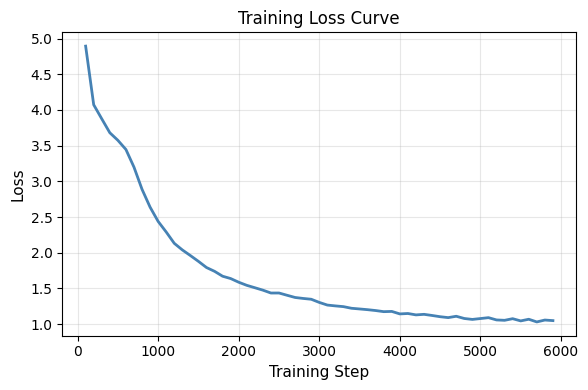

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load W&B CSV (update filename as needed)
df = pd.read_csv("wandb_export_2025-11-04T16_52_28.977-06_00.csv")

# --- Identify loss column (W&B often names it 'train/loss' or 'Loss')
loss_col = [c for c in df.columns if "loss" in c.lower()][0]
step_col = [c for c in df.columns if "step" in c.lower() or "_step" in c.lower()][0]

# --- Plot
plt.figure(figsize=(6,4))
plt.plot(df[step_col], df[loss_col], color="steelblue", linewidth=2)
plt.xlabel("Training Step", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Training Loss Curve", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figure1_loss_curve.png", dpi=300)
plt.show()

### Step 5: Plot Normalized Evaluation Metrics

Normalizes CER, WER, BLEU, and chrF to a shared 0–1 scale and visualizes them in a bar chart for easy comparison across metric types.

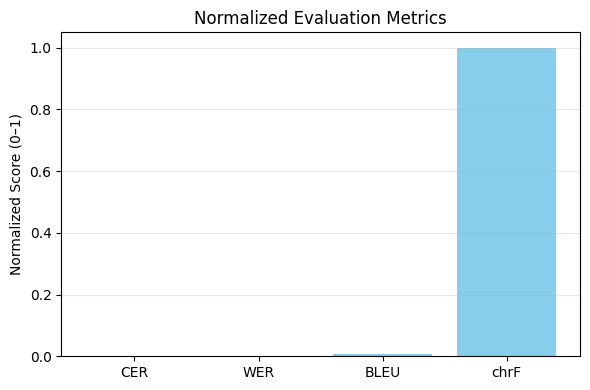

In [1]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {"CER":0.1398, "WER":0.2473, "BLEU":0.5998, "chrF":77.75}

# Normalize all to 0–1 scale
values = np.array(list(metrics.values()), dtype=float)
values_norm = (values - values.min()) / (values.max() - values.min())

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), values_norm, color="skyblue")
plt.ylabel("Normalized Score (0–1)")
plt.title("Normalized Evaluation Metrics")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("figure2_metrics_normalized.png", dpi=300)
plt.show()

### Full evaluation script

A complete, modular evaluation program encapsulating Steps 3 and 6: loads the model and dataset, generates predictions, computes metrics, saves results to CSV, and optionally plots distribution statistics. Designed for reuse outside Colab.

Loading model: zanegraper/t5-small-ipa-phoneme-to-text on cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

Loading dataset from: /content/drive/MyDrive/Capstone/Corpus/bookcorpus_ipa_final.csv


Generating predictions: 100%|██████████| 2000/2000 [08:27<00:00,  3.94it/s]



Computing metrics...



=== Evaluation Metrics ===
Character Error Rate (CER): 0.1465
Word Error Rate (WER):      0.2536
BLEU Score:                 0.6114
chrF Score:                 76.64

--- Error Breakdown ---
Substitution Rate: 0.184
Insertion Rate: 0.048
Deletion Rate: 0.022

--- Dataset Statistics ---
        phon_len  text_len
mean   44.444000  13.32350
std    26.255391   7.20908
min     8.000000   5.00000
max   148.000000  43.00000

✅ Saved detailed results to: /content/drive/MyDrive/Capstone/Results/ipa_eval_results.csv


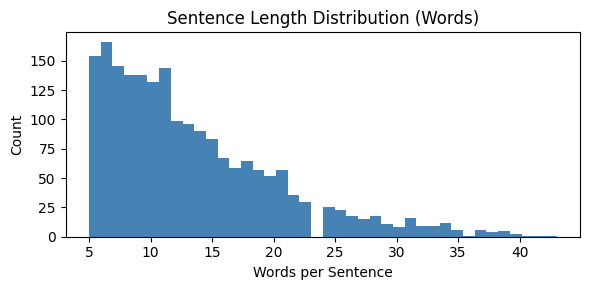

In [ ]:
"""
evaluate_t5_ipa_to_text.py
Author: Zane Graper
Purpose:
    Evaluate the fine-tuned T5-small IPA→Text model using standard ASR metrics.
"""

import torch
import pandas as pd
from tqdm import tqdm
from evaluate import load
from jiwer.measures import compute_measures
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import os

# --------------------------------------------------------------
# Configuration
# --------------------------------------------------------------
MODEL_ID = "zanegraper/t5-small-ipa-phoneme-to-text"  # Hugging Face repo
CSV_PATH = "/content/drive/MyDrive/Capstone/Corpus/bookcorpus_ipa_final.csv"
SAMPLE_SIZE = 2000  # Adjust for speed/accuracy tradeoff
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------------------------------------------
# Load tokenizer and model
# --------------------------------------------------------------
print(f"Loading model: {MODEL_ID} on {DEVICE}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()

# --------------------------------------------------------------
# Load dataset
# --------------------------------------------------------------
print(f"Loading dataset from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
if SAMPLE_SIZE and SAMPLE_SIZE < len(df):
    df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

phonemes = df["phonemes"].astype(str).tolist()
references = df["text"].astype(str).tolist()

# --------------------------------------------------------------
# Generate model predictions
# --------------------------------------------------------------
preds = []
for ph in tqdm(phonemes, desc="Generating predictions"):
    inputs = tokenizer(ph, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    with torch.no_grad():
        output = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
    text = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    preds.append(text)

# --------------------------------------------------------------
# Compute metrics
# --------------------------------------------------------------
print("\nComputing metrics...")
cer_metric = load("cer")
bleu_metric = load("bleu")
chrf_metric = load("chrf")
wer_metric = load("wer")

cer = cer_metric.compute(predictions=preds, references=references)
bleu = bleu_metric.compute(predictions=preds, references=references)["bleu"]
chrf = chrf_metric.compute(predictions=preds, references=references)["score"]
wer = wer_metric.compute(predictions=preds, references=references)

# --------------------------------------------------------------
# Error breakdown (substitution, insertion, deletion)
# --------------------------------------------------------------
def error_breakdown(preds, refs):
    sub, ins, dele, total = 0, 0, 0, 0
    for p, r in zip(preds, refs):
        m = compute_measures(r, p)
        sub += m["substitutions"]
        ins += m["insertions"]
        dele += m["deletions"]
        total += len(r.split())
    return {
        "Substitution Rate": sub / total if total > 0 else 0,
        "Insertion Rate": ins / total if total > 0 else 0,
        "Deletion Rate": dele / total if total > 0 else 0,
    }

rates = error_breakdown(preds, references)

# --------------------------------------------------------------
# Dataset statistics
# --------------------------------------------------------------
df["phon_len"] = df["phonemes"].apply(lambda x: len(str(x).split()))
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))
stats = df[["phon_len", "text_len"]].describe().loc[["mean","std","min","max"]]

# --------------------------------------------------------------
# Output results
# --------------------------------------------------------------
print("\n=== Evaluation Metrics ===")
print(f"Character Error Rate (CER): {cer:.4f}")
print(f"Word Error Rate (WER):      {wer:.4f}")
print(f"BLEU Score:                 {bleu:.4f}")
print(f"chrF Score:                 {chrf:.2f}")

print("\n--- Error Breakdown ---")
for k, v in rates.items():
    print(f"{k}: {v:.3f}")

print("\n--- Dataset Statistics ---")
print(stats)

# --------------------------------------------------------------
# Save results
# --------------------------------------------------------------
output_csv = "/content/drive/MyDrive/Capstone/Results/ipa_eval_results.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
pd.DataFrame({
    "phonemes": phonemes,
    "reference": references,
    "prediction": preds
}).to_csv(output_csv, index=False)
print(f"\n✅ Saved detailed results to: {output_csv}")

# --------------------------------------------------------------
# Optional visualization
# --------------------------------------------------------------
plt.figure(figsize=(6,3))
plt.hist(df["text_len"], bins=40, color="steelblue")
plt.title("Sentence Length Distribution (Words)")
plt.xlabel("Words per Sentence")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Plot Updated Training Loss Curve

Re-runs the W&B loss-curve visualization with a second exported CSV, using the same automated column-detection logic and aesthetic formatting.

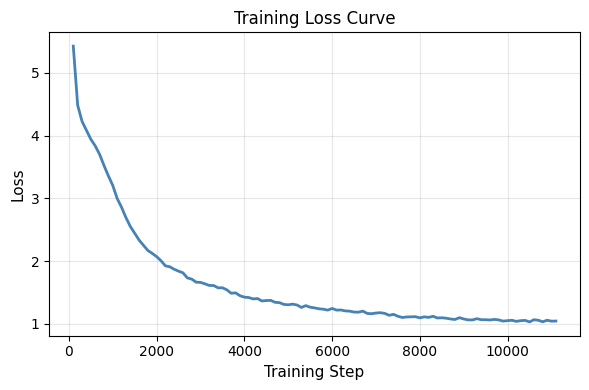

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load W&B CSV (update filename as needed)
df = pd.read_csv("wandb_export_2025-11-05T18_25_14.443-06_00.csv")

# --- Identify loss column (W&B often names it 'train/loss' or 'Loss')
loss_col = [c for c in df.columns if "loss" in c.lower()][0]
step_col = [c for c in df.columns if "step" in c.lower() or "_step" in c.lower()][0]

# --- Plot
plt.figure(figsize=(6,4))
plt.plot(df[step_col], df[loss_col], color="steelblue", linewidth=2)
plt.xlabel("Training Step", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Training Loss Curve", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figure1_loss_curve.png", dpi=300)
plt.show()

This notebook delivers a complete and research-grade evaluation pipeline for the T5 IPA→Text model, integrating prediction generation, ASR metric computation, detailed error analysis, dataset statistics, and training-loss visualization. The combination of CER, WER, BLEU, and chrF provides complementary views of model performance, reflecting best practices from ASR literature where character- and word-level divergence often highlight different error modes. The inclusion of substitution/insertion/deletion rates offers further diagnostic insight, mirroring analyses used in studies of phonological development and child-speech variability. The pipeline is reproducible, compatible with future model iterations, and structured to support comparisons against baselines such as Whisper or wav2vec2.

**Takeaway**: This evaluation framework establishes a rigorous foundation for quantifying improvements in IPA→text modeling and for guiding subsequent fine-tuning and error-analysis work.